In [4]:
using Plots 
using Revise
cd("..")
include("RBFunctions.jl")
cd("circular_stokes_flow")
include("kernel_definitions.jl")
using BenchmarkTools
using Symbolics
using Latexify
using CairoMakie

ABCD

10

set up the problem 
compute L_I L_b matrices 
Compute P matrix 


In [5]:
#generate points for circular flow benchmark 
using DistMesh2D
#d(p) = sqrt(sum(p.^2))-1
#p,t = distmesh(d,HUniform,0.2)
fdistance(p) = sqrt(sum(p .^ 2)) - 1
fedgelength(p) = 1/(sqrt(sum(p .^ 2))+1)
boundingbox = [-1.1 -1.1; 1.1 1.1]
initdistance = 0.1
x, y = distmesh2d(fdistance, fedgelength, boundingbox, initdistance)

# generate points, reference solution, forcing vector, and boundary conditions 
tx = unique(filter(e -> !isequal(e,NaN) ,x))
ty = unique(filter(e -> !isequal(e,NaN) ,y))

points = hcat(tx,ty)'

Internal_points = []
Boundary_points = []
suma = 0
for i in 1:length(tx)
    if abs(sum(points[:,i] .^2) - 1) < 1e-8
        #println(i)
        suma +=1
        append!(Boundary_points,[points[:,i]])
    else
        append!(Internal_points,[points[:,i]])
    end
    
end

Internal_points = hcat(Internal_points...)
Boundary_points = hcat(Boundary_points...)
All_points = hcat(Internal_points,Boundary_points)
N_i = size(Internal_points)[2]
N_b = size(Boundary_points)[2]
N = N_i + N_b
println("total number of nodes: ",N)


total number of nodes: 358


In [6]:
# generate vector functions 

#scatter(Internal_points[1,:],Internal_points[2,:],aspect_ratio=:equal)
#scatter!(Boundary_points[1,:],Boundary_points[2,:],aspect_ratio=:equal)
#@time u1(1)
tst1 = generate_vector_function(true_u₁,Internal_points)
tst2 = generate_vector_function(true_u₁,true_u₂,Internal_points)
println(length(tst1(100.0)))
println(length(tst2(100.0)))
ux_true = generate_vector_function(true_u₁,Internal_points)
uy_true = generate_vector_function(true_u₂,Internal_points)
u_true_internal = generate_vector_function(true_u₁,true_u₂,Internal_points)
g = generate_vector_function(true_u₁,true_u₂,Boundary_points) # function values on the boundary 
f = generate_vector_function(f₁,f₂,Internal_points) # forcing function on the domain 
∇p = generate_vector_function(true_∂₁p,true_∂₂p,Internal_points) # forcing function on the domain 
∂ₜg = generate_vector_function(true_∂ₜu₁,true_∂ₜu₂,Boundary_points)


294
588


(::var"#aa#120"{var"#149#150", var"#151#152", Vector{Float64}, Vector{Float64}, Int64}) (generic function with 1 method)

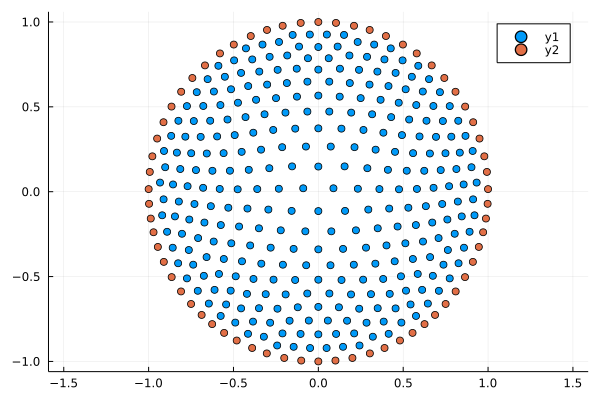

In [7]:
# plot the domain and boundary points 
Plots.scatter(Internal_points[1,:],Internal_points[2,:],aspect_ratio=:equal)
Plots.scatter!(Boundary_points[1,:],Boundary_points[2,:],aspect_ratio=:equal)

In [8]:


time = Observable(0.0)
xs = Internal_points[1,:]
ys = Internal_points[2,:]
us = @lift ux_true($time)
vs = @lift uy_true($time)
title = @lift string(round($time, digits=2))
strength2 = @lift (sqrt.(ux_true($time+0.01) .^ 2 .+ uy_true($time+0.01) .^ 2) )

fig = Figure(resolution = (800, 800))
Axis(fig[1, 1], backgroundcolor = "black",title = title)
arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.2, arrowcolor = strength2, linecolor = strength2) #, 
framerate = 30
timestamps = range(0.0, 2π, step=1/framerate)
record(fig, "time_animation.gif", timestamps; framerate = framerate) do ti
    time[] = ti
end
print(strength2)

Observable{Vector{Float64}} with 2 listeners. Value:
[2.185540621213016, 2.1153577067438607, 2.2108353598376946, 1.7240328436180277, 1.3018537875350582, 1.8790127201950602, 1.7336739307205422, 1.8855343400646576, 2.117571144289743, 1.4843448297636468, 2.1972691980416266, 1.8990158843946066, 2.164230061074157, 2.1526669514365424, 1.4423652812686183, 1.0781002318814952, 1.1330250565258688, 2.1526669526669417, 1.5230064293260286, 1.4423652809223442, 2.1642300602174314, 1.8990158857499562, 1.824169776452312, 1.5230064307340454, 1.133025055801209, 1.8241697767630034, 1.8063439346348344, 2.115357706023273, 1.4843448286099359, 1.7336739296204409, 1.8790127183131071, 1.3018537877632974, 2.1175711433211326, 1.8855343369650917, 2.185540618190807, 1.724032843585801, 2.210835360398468, 2.197269196756738, 2.141510274129626, 2.171944821554748, 1.864501009267548, 2.1721316614873105, 2.140989356822219, 2.150914553304577, 1.7899928099709923, 1.433237767730371, 1.7907682550868231, 1.8076751966613374, 1.

In [9]:
#apply matrix kernel to a distance matrix 
# test this function
test_tensor = point_difference_tensor(Internal_points[:,1:3],Internal_points[:,1:3])
display(apply_matrix(Φ_div, test_tensor, 2))
Φ_div(test_tensor[3,1,:],2)


6×6 Matrix{Float64}:
  8.0       0.0        5.11928   -1.44887    3.44748   -2.10889
  0.0       8.0       -1.44887    2.80604   -2.10889    0.519077
  5.11928  -1.44887    8.0        0.0        7.55782   -0.250302
 -1.44887   2.80604    0.0        8.0       -0.250302   7.34276
  3.44748  -2.10889    7.55782   -0.250302   8.0        0.0
 -2.10889   0.519077  -0.250302   7.34276    0.0        8.0

2×2 Matrix{Float64}:
  3.44748  -2.10889
 -2.10889   0.519077

In [10]:
# calculate matrices for the simulation 
using DoubleFloats
param = 5
tensor_internal_internal =(point_difference_tensor(Internal_points,Internal_points))
tensor_internal_all = (point_difference_tensor(Internal_points,All_points))
tensor_all_all = (point_difference_tensor(All_points,All_points))
tensor_internal_boundary = (point_difference_tensor(Internal_points,Boundary_points))
tensor_boundary_boundary = (point_difference_tensor(Boundary_points,Boundary_points))


"""
mA_internal = apply_matrix(Φ, tensor_internal_internal, param)
mA_div_internal = apply_matrix(Φ_div, tensor_internal_internal, param)
mP = A_div_internal*inv(mA_internal)

mB =  apply_matrix(ΔΦ_normal, tensor_internal_all, param)
mA = apply_matrix(Φ, tensor_all_all, param)
mL = mB*inv(mA)
mL_i = mL[:,1:2*N_i]
mL_b = mL[:,2*N_i+1:end]

println("cond A_internal:", cond(mA_internal))
#println("cond A_div_internal:", cond(mA_div_internal))
println("cond A:", cond(mA))

println("cond P*L_i:", cond(mP*mL_i))
#println("cond L_i:", cond(mP*mL_i))
#println("max Li: ",maximum(real.(eigvals(mL_i))))
println("max eigenval P*Li: ",maximum(real.(eigvals(mP*mL_i))))



"""
# from the paper 
A = (apply_matrix(Φ, tensor_internal_internal, param))
A_div = (apply_matrix(Φ_div, tensor_internal_internal, param))
B = (apply_matrix(Φ_div, tensor_internal_boundary, param))
C = (apply_matrix(Φ_div, tensor_boundary_boundary, param))

AA = vcat(hcat(A,B),hcat(B',C))
AB = hcat(A_div,B)
Px = AB*inv(AA)
Pi = Px[:,1:2*N_i]
Pb = Px[:,2*N_i+1:end]

Ax = (apply_matrix(Φ_normal, tensor_all_all, param))
AL = (apply_matrix(ΔΦ_normal, tensor_all_all, param))
L = AL*inv(Ax)
Li = L[1:2*N_i,1:2*N_i]
Lb = L[1:2*N_i,2*N_i+1:end]

println("cond AA: ",cond(AA))
println("cond Ax: ",cond(Ax))
println("cond Pi*Li :",cond(Pi*Li))
println("max eigenval: ",maximum(real.(eigvals(Pi*Li))))




cond AA: 4.251558311546112e6
cond Ax: 496672.5908820539
cond Pi*Li :6.965144683944855e12
max eigenval: -2.546325620898836e-10


In [11]:
using DifferentialEquations
using Sundials
function f1!(du,u,p,t) # my version
    L_i = p[1]
    L_b = p[2]
    P = p[3]
    f = p[4]
    g = p[5]
    ∇p = p[6]
    du .=  P*(L_i * u .+ L_b * g(t) .+ f(t))
    #return du
end

function f2!(du,u,p,t) # paper version
    Li,Lb,Pi,Pb,f,g,∂ₜg, ∇p = p

    du .=   Pi * (Li * u .+ Lb * g(t) .+ f(t) ) .+ Pb*∂ₜg(t)
end

u0 = u_true_internal(0)
tspan = (0.0,2.0)
#prob1 = ODEProblem(f1!,u0,tspan,[mL_i,mL_b,mP,f,g,∇p])
prob2 = ODEProblem(f2!,u0,tspan,[Li,Lb,Pi,Pb,f,g,∂ₜg,∇p])
sol = solve(prob2,ImplicitEuler())
println("done")

done


In [12]:
println(maximum(abs.(sol(1.3) - u_true_internal(1.3))))
println(maximum(vcat(sol[:]...)))
println(maximum(vcat(u_true_internal.(0:0.1:2)...)))
maximum(abs.(vcat(u_true_internal.(0:0.01:2)...) - vcat(sol(0:0.01:2)...)))


0.01819707889307476
2.887982723073977
2.872242156246089


0.020303944321505174

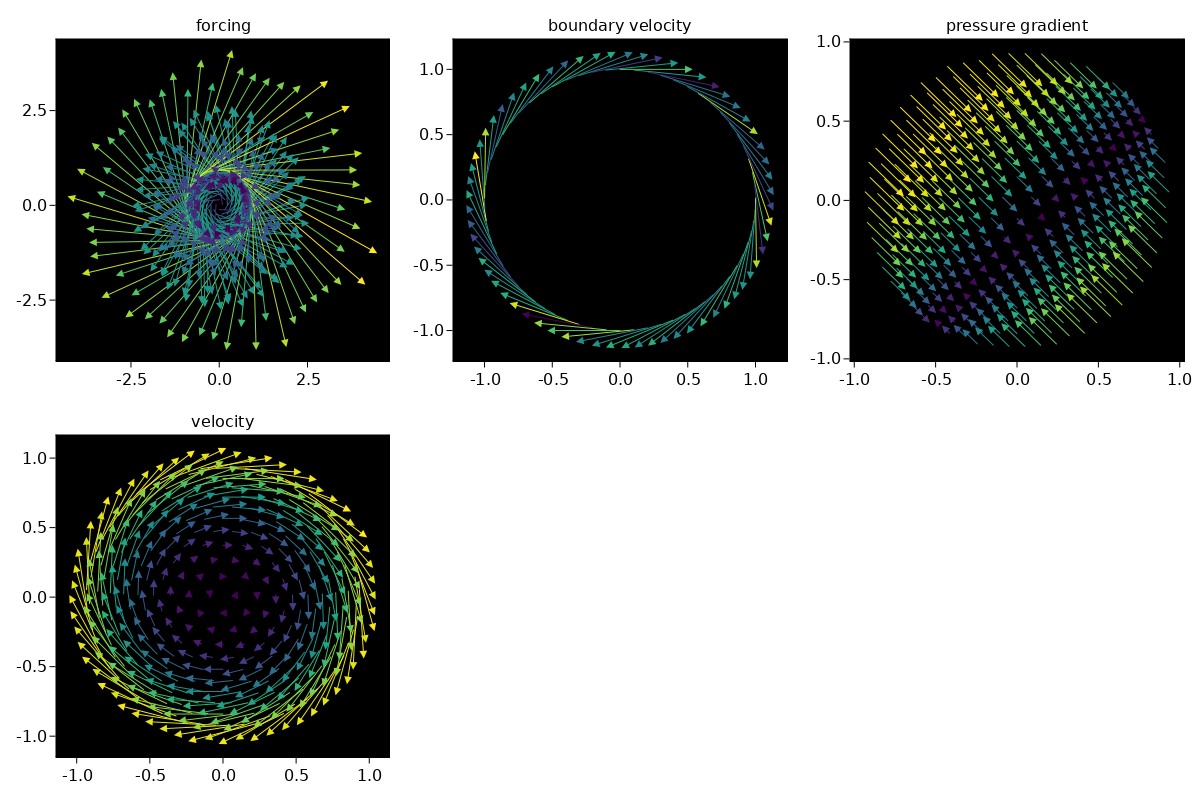

In [13]:

t_interest = 1.3
xsi = Internal_points[1,:]
ysi = Internal_points[2,:]

u = sol(t_interest)[1:2:2*N_i]
v = sol(t_interest)[2:2:2*N_i]

usi = f(t_interest)[1:2:2*N_i]
vsi = f(t_interest)[2:2:2*N_i]

up = ∇p(t_interest)[1:2:2*N_i]
vp = ∇p(t_interest)[2:2:2*N_i]

xsb = Boundary_points[1,:]
ysb = Boundary_points[2,:]
usb = g(t_interest)[1:2:2*N_b]
vsb = g(t_interest)[2:2:2*N_b]

strengthi = (sqrt.( usi.^ 2 .+  vsi.^ 2) )
strengthb = (sqrt.( usb.^ 2 .+  vsb.^ 2) )
strengthp = (sqrt.( (up.+0.0).^ 2 .+  (vp .+0.0).^ 2) )
strengthsol = (sqrt.( (u.+0.0).^ 2 .+  (v .+0.0).^ 2) )

fig = Figure(resolution = (3*400, 2*400))
subfig1 = fig[1, 1] = GridLayout()
subfig2 = fig[1, 2] = GridLayout()
subfig3 = fig[1, 3] = GridLayout()
subfig4 = fig[2, 1] = GridLayout()
ax1 = Axis(subfig1[1, 1], backgroundcolor = "black",title = "forcing")
ax2 = Axis(subfig2[1, 1], backgroundcolor = "black",title = "boundary velocity")
ax3 = Axis(subfig3[1, 1], backgroundcolor = "black",title = "pressure gradient")
ax4 = Axis(subfig4[1, 1], backgroundcolor = "black",title = "velocity")
arrows!(ax1,xsi, ysi, usi, vsi, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthi, linecolor = strengthi) #,
arrows!(ax2,xsb, ysb, usb, vsb, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthb, linecolor = strengthb) #,
arrows!(ax3,xsi, ysi, up, vp, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthp, linecolor = strengthp) #,
arrows!(ax4,xsi, ysi,u , v, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthsol, linecolor = strengthsol)
fig
#save("testingg.png",fig)

#println(up .^2 .+ vp .^2)

In [14]:
time = Observable(0.0)
xs = Internal_points[1,:]
ys = Internal_points[2,:]
us = @lift sol($time)[1:2:2*N_i]
vs = @lift sol($time)[2:2:2*N_i]
title = @lift string(round($time, digits=2))
strength2 = @lift sqrt.(sol($time+0.01)[1:2:2*N_i] .^ 2 .+ sol($time+0.01)[2:2:2*N_i] .^ 2) 

fig = Figure(resolution = (800, 800))
Axis(fig[1, 1], backgroundcolor = "black",title = title)
arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.05, arrowcolor = strength2, linecolor = strength2) #, 
framerate = 30
timestamps = range(0.0, 2, step=1/framerate)
record(fig, "my_method.gif", timestamps; framerate = framerate) do ti
    time[] = ti
end


"my_method.gif"